# Testing Deferred Revenue in Python
Will this be easier for everyone to use than Matlab?

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Step 1: Processing Base Billings Data

In [60]:
df = pd.read_excel('../data/old/base_billings.xlsx', sheet_name='bill_DC')

In [61]:
df.sample(10)

,Document Currency,Enterprise Bu,Frequency,Invoicing Fiscal Year-Period Desc,Product Configtype ID,Revenue Recognition Category New,Rule For Bill Date,Sales Type,Subscription Term,Completed Sales Doc Currency
21850,NOK,Print & Publishing,NaN,2017-05,1Y,D,Y3,DEFERRED,1,16690.00
23679,USD,Creative,NaN,2015-06,1Y,D,YQ,DEFERRED,12,128633.33
21939,NZD,Experience Cloud,NaN,2018-05,NaN,NaN,NaN,RECOGNIZED,0,0.00
23927,USD,Creative,NaN,2015-11,1Y,D,YH,DEFERRED,0,28750.00
1522,AUD,Document Cloud,NaN,2018-10,1Y,D,Y3,DEFERRED,0,5082.50
6507,DKK,Creative,NaN,2015-07,NaN,D,YA,DEFERRED,12,660.00
19314,JPY,Experience Cloud,1TME,2016-09,NaN,NaN,NaN,RECOGNIZED,0,50717009.00
24210,USD,Creative,NaN,2016-06,NaN,NaN,NaN,DEFERRED,0,0.00
25644,USD,Document Cloud,NaN,2015-10,1Y,A,NaN,DEFERRED,12,3479821.77
13599,GBP,Creative,NaN,2017-01,NaN,NaN,NaN,RECOGNIZED,0,457327.53


## Filter that removes any currency that has  < 10 transactions. 


In [62]:
# creates a list of the currencies and the number of transactions for each currency
vc = df['Document Currency'].value_counts()

In [63]:
# Create variable that is true if the number of transaction is greater than 10, false otherwise
keep_these = vc.values > 10
# filtering only currencies that were greater than 10
keep_curr = vc[keep_these]
a = keep_curr.index
# filtering the dataframe to remove any of teh currencies not in our list
df = df[df['Document Currency'].isin(a)]

## Just keeping track of the currencies we removed in our model_dict data strucutre

In [64]:
remove_these = vc.values <= 10
model_dict = {'curr_removed': list(vc[remove_these].index)}
model_dict

{'curr_removed': ['CLP', 'COP', 'ARS', 'PEN', 'BMD', 'MXP', 'INR']}

# Removing any of the values that are zero

In [65]:
print('This is the length of the dataframe before removing zeros: ', len(df))
df = df[df['Completed Sales Doc Currency']!=0]
print('This is the length of the dataframe after removing zeros: ', len(df))

This is the length of the dataframe before removing zeros:  31418
This is the length of the dataframe after removing zeros:  28896


In [66]:
df.sample(20)

,Document Currency,Enterprise Bu,Frequency,Invoicing Fiscal Year-Period Desc,Product Configtype ID,Revenue Recognition Category New,Rule For Bill Date,Sales Type,Subscription Term,Completed Sales Doc Currency
7557,DKK,Experience Cloud,ACTL,2017-06,ONORE,NaN,NaN,RECOGNIZED,0,20000.00
12099,EUR,Experience Cloud,1TME,2019-01,ONORE,NaN,NaN,RECOGNIZED,0,326766.94
11714,EUR,Experience Cloud,ACTL,2018-05,ONORE,NaN,NaN,RECOGNIZED,0,633856.39
27877,USD,Experience Cloud,ONGO,2016-07,ONORE,D,YH,DEFERRED,0,118962.20
16467,GBP,LiveCycle,NaN,2017-12,NaN,NaN,NaN,RECOGNIZED,0,2024.00
23837,USD,Creative,1TME,2015-09,OCONS,NaN,NaN,PRO-SVC-INV,0,370665.63
20602,NOK,Creative,NaN,2015-06,NaN,NaN,NaN,RECOGNIZED,0,432748.00
23371,SEK,Experience Cloud,1TME,2018-12,OCONS,B,NaN,DEFERRED,0,172520.00
5151,CHF,Creative,NaN,2018-05,1Y,A,NaN,DEFERRED,12,-19407.28
6170,CHF,Experience Cloud,ONGO,2018-09,1Y,D,YA,DEFERRED,12,216185.00


## Clearing out the Non-Revenue billings from the file
 - No Idea what these are

In [67]:
df['Sales Type'].value_counts()

DEFERRED       22919
RECOGNIZED      5041
PRO-SVC-INV      844
NON-REV           92
Name: Sales Type, dtype: int64

In [68]:
print('Length of the dataframe before removing non-revenue billings: ', len(df))
df = df[df['Sales Type']!='NON-REV']
print('Length of the dataframe after removing non-revenue billings:  ', len(df))


Length of the dataframe before removing non-revenue billings:  28896
Length of the dataframe after removing non-revenue billings:   28804


## Starting to group the revenue by period, industry, etc

Attempting to group by the following categories
 - currency
 - period
 - sale type
 
May need to process the data differently with the deferred billings so we will start with the recognized and then the service billings

# DOING THIS ALL IN PANDAS WITH SPLIT APPLY COMBINE on Sales Type 


In [69]:
# First split the data into three dataframes
# Recognized billings
rec = df[df['Sales Type']=='RECOGNIZED']
svc = df[df['Sales Type']=='PRO-SVC-INV']
dfr = df[df['Sales Type']=='DEFERRED']

In [70]:
rec.columns

Index(['Document Currency', 'Enterprise Bu', 'Frequency',
       'Invoicing Fiscal Year-Period Desc', 'Product Configtype ID',
       'Revenue Recognition Category New', 'Rule For Bill Date', 'Sales Type',
       'Subscription Term', 'Completed Sales Doc Currency'],
      dtype='object')

### Recognized Revenue

# NOW WORKING ON THE REVENUE

In [71]:
rec.sample(10)

,Document Currency,Enterprise Bu,Frequency,Invoicing Fiscal Year-Period Desc,Product Configtype ID,Revenue Recognition Category New,Rule For Bill Date,Sales Type,Subscription Term,Completed Sales Doc Currency
4379,CAD,Experience Cloud,1TME,2018-03,NaN,NaN,NaN,RECOGNIZED,0,40320.00
11412,EUR,Experience Cloud,ACTL,2017-11,ONORE,NaN,NaN,RECOGNIZED,0,903954.34
19141,JPY,Experience Cloud,1TME,2015-12,ONORE,NaN,NaN,RECOGNIZED,0,9727250.99
14027,GBP,Creative,NaN,2019-01,NaN,NaN,NaN,RECOGNIZED,0,104470.47
8174,EUR,Creative,NaN,2016-02,1V,NaN,NaN,RECOGNIZED,0,8694.00
12048,EUR,Experience Cloud,1TME,2018-12,ONORE,NaN,NaN,RECOGNIZED,0,45148.07
21186,NOK,Document Cloud,NaN,2016-10,NaN,NaN,NaN,RECOGNIZED,0,746.00
7770,DKK,Other Solutions,NaN,2017-07,NaN,NaN,NaN,RECOGNIZED,0,-92.50
1650,AUD,Experience Cloud,ACTL,2015-06,ONORE,NaN,NaN,RECOGNIZED,0,5195383.69
24289,USD,Creative,NaN,2016-07,UPG1,NaN,NaN,RECOGNIZED,0,7965.00


In [72]:
# testing groupby object
gb_rec = rec.groupby(['Document Currency', 'Enterprise Bu', 'Invoicing Fiscal Year-Period Desc'], as_index=False).sum()

In [73]:
# the Subscription term hangs around. We are dropping that here
gb_rec.drop(labels='Subscription Term', axis=1,inplace =True)

In [29]:
gb_rec

,Document Currency,Enterprise Bu,Invoicing Fiscal Year-Period Desc,Completed Sales Doc Currency
0,AUD,Creative,2015-06,490156.86
1,AUD,Creative,2015-07,235045.62
2,AUD,Creative,2015-08,284334.70
3,AUD,Creative,2015-09,369648.88
4,AUD,Creative,2015-10,287292.48
5,AUD,Creative,2015-11,361723.22
6,AUD,Creative,2015-12,276178.28
7,AUD,Creative,2016-01,270306.21
8,AUD,Creative,2016-02,116996.45
9,AUD,Creative,2016-03,235382.84


In [74]:
print(type(gb_rec))

<class 'pandas.core.frame.DataFrame'>


## Now doing this for the service billings

In [75]:
# testing groupby object
gb_svc = svc.groupby(['Document Currency', 'Enterprise Bu', 'Invoicing Fiscal Year-Period Desc'], as_index=False).sum()

In [76]:
gb_svc.drop(labels='Subscription Term', axis=1,inplace =True)
gb_svc

,Document Currency,Enterprise Bu,Invoicing Fiscal Year-Period Desc,Completed Sales Doc Currency
0,AUD,Experience Cloud,2015-06,589499.45
1,AUD,Experience Cloud,2015-07,656493.50
2,AUD,Experience Cloud,2015-08,370780.74
3,AUD,Experience Cloud,2015-09,1251726.13
4,AUD,Experience Cloud,2015-10,291324.07
5,AUD,Experience Cloud,2015-11,770327.50
6,AUD,Experience Cloud,2015-12,700684.00
7,AUD,Experience Cloud,2016-01,528857.50
8,AUD,Experience Cloud,2016-02,367175.25
9,AUD,Experience Cloud,2016-03,974604.14


# NOW WORKING ON DEFERRED BILLINGS

## Type B billings are service agreements that will have invoices submitted before the billings are reclassified to revenue. If no invoices are assigned to the billings, the billings become revenue in 12 months

In [77]:
# filter out the type B first then do a group_by
dfr_b = dfr[dfr['Revenue Recognition Category New']=='B']

In [85]:
gb_b = dfr_b.groupby(['Document Currency', 'Enterprise Bu', 'Invoicing Fiscal Year-Period Desc'], as_index=False).sum()

In [86]:
gb_b.head(10)

,Document Currency,Enterprise Bu,Invoicing Fiscal Year-Period Desc,Subscription Term,Completed Sales Doc Currency
0,AUD,Creative,2017-10,0,8544.00
1,AUD,Document Cloud,2017-12,0,3283.20
2,AUD,Document Cloud,2018-06,0,3425.00
3,AUD,Document Cloud,2018-12,0,3425.00
4,AUD,Document Cloud,2019-03,0,4375.00
5,AUD,Experience Cloud,2015-06,0,258231.69
6,AUD,Experience Cloud,2015-07,0,261159.25
7,AUD,Experience Cloud,2015-08,0,270139.50
8,AUD,Experience Cloud,2015-09,0,482725.30
9,AUD,Experience Cloud,2015-10,0,287254.60


In [87]:
gb_b.drop(labels='Subscription Term', axis=1, inplace=True)

In [88]:
dfr.columns

Index(['Document Currency', 'Enterprise Bu', 'Frequency',
       'Invoicing Fiscal Year-Period Desc', 'Product Configtype ID',
       'Revenue Recognition Category New', 'Rule For Bill Date', 'Sales Type',
       'Subscription Term', 'Completed Sales Doc Currency'],
      dtype='object')

In [89]:
print(len(dfr))

22919


In [90]:
print(len(dfr_b))

997


## Now Type A Billings
These billings are on a billing plan. The product config tells us how long before they renew

 - '2Y' = 24 months
 - '1Y' = 12 months
 - 'MTHLY' = 1 month
 
NOTE: There are also other fields in the 'Product Configtype ID' field that do not map well to a rebill period.
To fix this, we need to load up a different file and determine the length of the sales contract (type A no config)
 

In [92]:
# filtering just the type A billings
dfr_a = dfr[dfr['Revenue Recognition Category New']=='A']

In [93]:
gb_a = dfr_a.groupby(['Document Currency', 'Enterprise Bu', 'Invoicing Fiscal Year-Period Desc',
                     'Product Configtype ID'], as_index=False).sum()
gb_a.drop(labels='Subscription Term', axis=1, inplace = True)

In [94]:
gb_a.sample(10)

,Document Currency,Enterprise Bu,Invoicing Fiscal Year-Period Desc,Product Configtype ID,Completed Sales Doc Currency
3218,USD,Document Cloud,2017-02,1Y,7366879.09
323,AUD,Experience Cloud,2019-02,1Y,-207363.02
817,CHF,Experience Cloud,2017-09,1Y,98916.56
1620,EUR,Print & Publishing,2018-09,2Y,24651.00
1327,EUR,Document Cloud,2017-11,MTHLY,-1659.91
1706,GBP,Creative,2017-06,MTHLY,-25050.98
1507,EUR,Other Solutions,2016-07,OUNIV,61054.00
550,CAD,Experience Cloud,2016-06,1Y,39578.00
3331,USD,Experience Cloud,2015-12,2Y,1314.00
1932,GBP,Experience Cloud,2017-10,1Y,189098.19


In [95]:
gb_a['Product Configtype ID'].value_counts()

1Y       1856
MTHLY     823
2Y        657
OUNIV     171
OCONS      62
3Y         46
ONORE      28
Name: Product Configtype ID, dtype: int64

In [96]:
gb_a_config = gb_a.groupby(['Product Configtype ID'], as_index=False).sum()

In [97]:
gb_a_config

,Product Configtype ID,Completed Sales Doc Currency
0,1Y,6.471612e+10
1,2Y,1.973660e+08
2,3Y,8.787511e+07
3,MTHLY,-1.982427e+07
4,OCONS,2.883743e+07
5,ONORE,2.258881e+06
6,OUNIV,3.328696e+06


<BarContainer object of 7 artists>

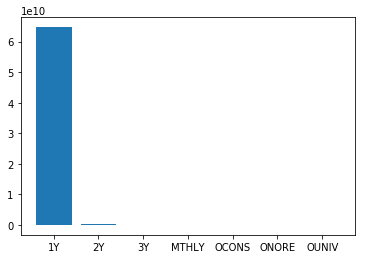

In [55]:
plt.bar(gb_a_config['Product Configtype ID'], gb_a_config['Completed Sales Doc Currency'])

### These type A amounts are very small!

In [56]:
# OK now lets just filter this gb_a to only be 1Y, 2Y, 3Y and MTHLY

In [101]:
config_list = ['1Y', '2Y', '3Y', 'MTHLY']
test1 = gb_a['Product Configtype ID'].isin(config_list)
sum(test1)

3382

In [ ]:
gb_a_known = gb_a[gb_a]

In [103]:
test1 = gb_a[gb_a['Product Configtype ID'].isin(config_list)]

## For now, lets just split this into gb_a_1Y, gb_a_2Y, gb_a_3y, gb_a_1M


In [110]:
gb_a_1Y = test1[test1['Product Configtype ID']=='1Y']
gb_a_2Y = test1[test1['Product Configtype ID']=='2Y']
gb_a_3Y = test1[test1['Product Configtype ID']=='3Y']
gb_a_1M = test1[test1['Product Configtype ID']=='MTHLY']

,Document Currency,Enterprise Bu,Invoicing Fiscal Year-Period Desc,Product Configtype ID,Completed Sales Doc Currency
2986,SEK,Print & Publishing,2017-04,1Y,1410.00
2907,SEK,Document Cloud,2017-09,1Y,-1669.83
508,CAD,Document Cloud,2015-09,1Y,71738.88
30,AUD,Creative,2016-04,1Y,1421144.78
1487,EUR,LiveCycle,2018-09,1Y,63909.59
3478,USD,LiveCycle,2017-09,1Y,333609.21
2066,GBP,Print & Publishing,2017-10,1Y,173689.20
3491,USD,LiveCycle,2018-10,1Y,143768.96
3173,USD,Document Cloud,2015-11,1Y,10492148.65
3021,USD,Creative,2015-12,1Y,79462165.78


# TYPE D billings
These billings have a field 'Rule For Bill Date' that determines when new billings will occur
 - Monthly [Y1, Y2, Y3, Y5]
 - Quarterly [YQ]
 - Every 4 months [YT]
 - Semi-annual [YH]
 - Annual [YA, YC]
 - Every 2 years - [Y4]
 
 We also need to track the type D billings that do not have a 'Rule for Bill Date'

In [130]:
# for now just do a groupby on the type
# filtering just the type A billings
dfr_d = dfr[dfr['Revenue Recognition Category New']=='D']

In [131]:
gb_d = dfr_d.groupby(['Document Currency', 'Enterprise Bu', 'Invoicing Fiscal Year-Period Desc',
                     'Rule For Bill Date'], as_index=False).sum()
gb_d.drop(labels='Subscription Term', axis=1, inplace = True)

In [132]:
gb_d_mthly = gb_d[gb_d['Rule For Bill Date'].isin(['Y1', 'Y2', 'Y3', 'Y5'])]
gb_d_qtrly = gb_d[gb_d['Rule For Bill Date']=='YQ']
gb_d_four_mths = gb_d[gb_d['Rule For Bill Date']=='YT']
gb_d_semi_ann = gb_d[gb_d['Rule For Bill Date']=='YH']
gb_d_annual = gb_d[gb_d['Rule For Bill Date'].isin(['YA', 'YC'])]
gb_d_two_yrs = gb_d[gb_d['Rule For Bill Date']=='Y4']

In [133]:
gb_d['Rule For Bill Date'].value_counts()

YA    1630
Y3    1438
YQ     530
Y1     256
YC     246
YH     243
Y2      95
Y4      23
Y7      18
YT       8
BT       1
Name: Rule For Bill Date, dtype: int64

### Note: There is one type D billings that is listed as 'BT' I don't know what this means, but it was a $180 EUR payment from January 2017, so we will ignore

In [134]:
print('Length of monthly', len(gb_d_mthly))
print('Length of quarterly', len(gb_d_qtrly))
print('Length of four months', len(gb_d_four_mths))
print('Length of semi ann', len(gb_d_semi_ann))
print('Length of annual', len(gb_d_annual))
print('Length of two years', len(gb_d_two_yrs))

Length of monthly 1789
Length of quarterly 530
Length of four months 8
Length of semi ann 243
Length of annual 1876
Length of two years 23


In [141]:
what_is_BT = gb_d[gb_d['Rule For Bill Date']=='YT']
what_is_BT.head(10)

,Document Currency,Enterprise Bu,Invoicing Fiscal Year-Period Desc,Rule For Bill Date,Completed Sales Doc Currency
4054,USD,Experience Cloud,2015-06,YT,11666.60
4068,USD,Experience Cloud,2015-08,YT,549861.11
4081,USD,Experience Cloud,2015-10,YT,11666.60
4101,USD,Experience Cloud,2016-01,YT,612916.60
4106,USD,Experience Cloud,2016-02,YT,-601250.00
4166,USD,Experience Cloud,2016-12,YT,13440.00
4190,USD,Experience Cloud,2017-04,YT,13440.00
4214,USD,Experience Cloud,2017-08,YT,13440.00


## Note: There are only 8 payments (back from 2017) that paid on a 4 month basis. 
We will ignore these as well.

## NOW WE NEED TO BUILD A DATAFRAME THAT INTEGRATES THIS DATA

- We will have the following descriptive fields
   - Invoicing Fiscal Year-Period
   - Document Currency
   - Enterprise BU

- We will have the following fields based on rebilling rule
   - Recognized
   - Service
   - Monthly
   - Quarterly
   - Annual
   - Two Years
   - Three Years

In [145]:
# starting with service and revenue
df_merge1 = pd.merge(gb_rec, gb_svc, how='outer', 
                     left_on=['Document Currency', 'Enterprise Bu', 'Invoicing Fiscal Year-Period Desc'],
                    right_on=['Document Currency', 'Enterprise Bu', 'Invoicing Fiscal Year-Period Desc'])

In [149]:
df_merge1.tail()

,Document Currency,Enterprise Bu,Invoicing Fiscal Year-Period Desc,Completed Sales Doc Currency_x,Completed Sales Doc Currency_y
2297,USD,Print & Publishing,2018-12,5894484.54,NaN
2298,USD,Print & Publishing,2019-01,1837388.61,NaN
2299,USD,Print & Publishing,2019-02,3201493.47,NaN
2300,USD,Print & Publishing,2019-03,15516091.68,180000.00
2301,CAD,Experience Cloud,2016-08,NaN,56215.21


In [144]:
gb_rec.columns

Index(['Document Currency', 'Enterprise Bu',
       'Invoicing Fiscal Year-Period Desc', 'Completed Sales Doc Currency'],
      dtype='object')